## Librerías

In [1]:
!pip install nltk scikit-learn matplotlib seaborn wordcloud

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [3]:
# Preprocesamiento de texto
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [4]:
# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import joblib

In [5]:
# Configuración de gráficas
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("✅ Librerías cargadas correctamente")

✅ Librerías cargadas correctamente


## Data

In [6]:
df = pd.read_csv("phishing_email.csv")

In [7]:
print(f"📊 Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
print("\nPrimeras filas:")
df.head()

📊 Dataset cargado: 45460 filas, 2 columnas

Primeras filas:


,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0.0
1,nom actual vols 24 th forwarded sabrae zajac h...,0.0
2,enron actuals march 30 april 1 201 estimated a...,0.0
3,hpl nom may 30 2001 see attached file hplno 53...,0.0
4,hpl nom june 1 2001 see attached file hplno 60...,0.0


## Exploración


📈 Distribución de clases:
label
0.0    23976
1.0    21483
Name: count, dtype: int64


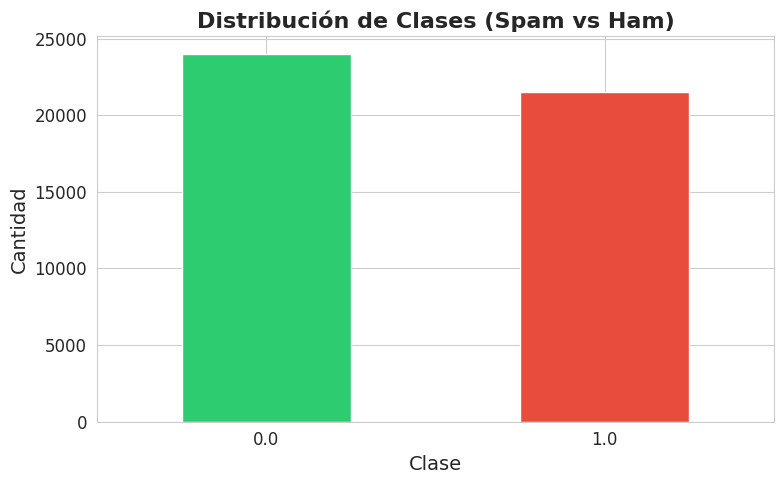

In [8]:

label_col = 'label'

print(f"\n📈 Distribución de clases:")
print(df[label_col].value_counts())

# Gráfica de barras
fig, ax = plt.subplots(figsize=(8, 5))
df[label_col].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c'], ax=ax)
ax.set_title('Distribución de Clases (Spam vs Ham)', fontsize=16, fontweight='bold')
ax.set_xlabel('Clase', fontsize=14)
ax.set_ylabel('Cantidad', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

## Preprocesamiento

In [9]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Limpia y tokeniza el texto:
    - Convierte a minúsculas
    - Elimina caracteres especiales y números
    - Tokeniza
    - Elimina stopwords
    - Retorna texto limpio
    """
    # Minúsculas
    text = text.lower()
    # Solo letras
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenizar
    tokens = word_tokenize(text)
    # Quitar stopwords
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

# Aplicar preprocesamiento (puede tardar unos minutos)
print("🔄 Preprocesando textos...")
df['text_clean'] = df['text_combined'].apply(preprocess_text)
print("✅ Textos preprocesados")

# Ver ejemplo
print(f"\nTexto original:\n{df['text_combined'].iloc[0][:200]}")
print(f"\nTexto limpio:\n{df['text_clean'].iloc[0][:200]}")


🔄 Preprocesando textos...
✅ Textos preprocesados

Texto original:
hpl nom may 25 2001 see attached file hplno 525 xls hplno 525 xls

Texto limpio:
hpl nom may see attached file hplno xls hplno xls


## Nube de palabras

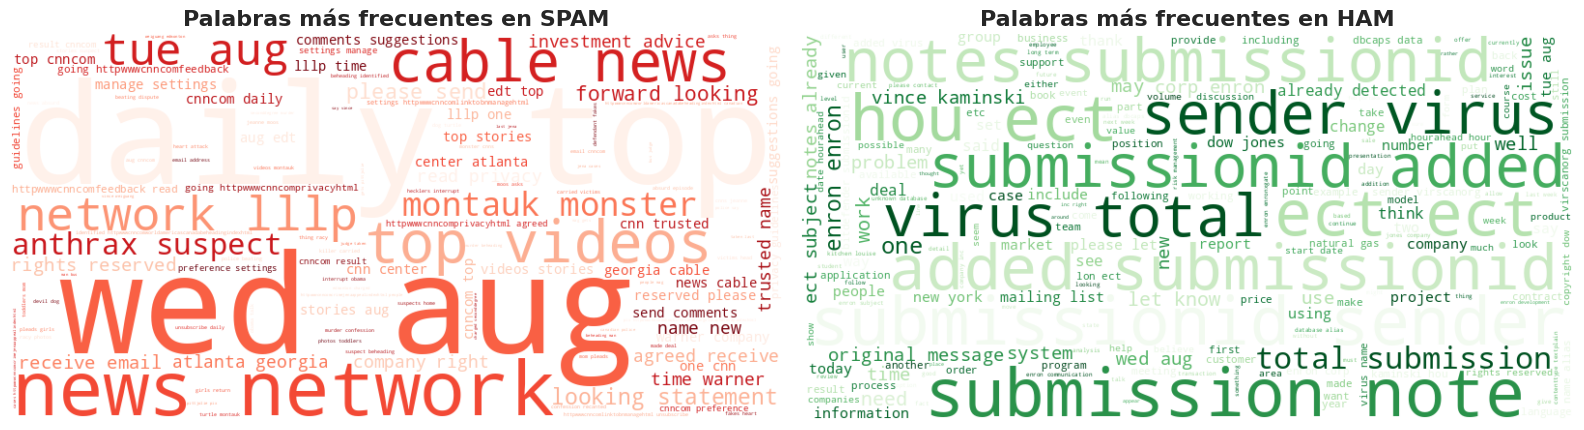

In [10]:
# Separar textos por clase
spam_text = ' '.join(df[df[label_col] == 1]['text_clean'])  # Asume 1=spam, 0=ham
ham_text = ' '.join(df[df[label_col] == 0]['text_clean'])

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# WordCloud de spam
wc_spam = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(spam_text)
axes[0].imshow(wc_spam, interpolation='bilinear')
axes[0].set_title('Palabras más frecuentes en SPAM', fontsize=16, fontweight='bold')
axes[0].axis('off')

# WordCloud de ham
wc_ham = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(ham_text)
axes[1].imshow(wc_ham, interpolation='bilinear')
axes[1].set_title('Palabras más frecuentes en HAM', fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()


## Train-test split

In [15]:
df = df.dropna()

In [16]:
X = df['text_clean']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📦 Datos divididos:")
print(f"   Entrenamiento: {len(X_train)} correos")
print(f"   Prueba: {len(X_test)} correos")

📦 Datos divididos:
   Entrenamiento: 36367 correos
   Prueba: 9092 correos


## TF-IDF

In [17]:
print("🔄 Vectorizando con TF-IDF...")
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"✅ Vectorización completada")
print(f"   Shape entrenamiento: {X_train_tfidf.shape}")
print(f"   Shape prueba: {X_test_tfidf.shape}")

🔄 Vectorizando con TF-IDF...
✅ Vectorización completada
   Shape entrenamiento: (36367, 10000)
   Shape prueba: (9092, 10000)


## Train

In [20]:
print("🚀 Entrenando modelo SVM lineal...")
model = LinearSVC(random_state=42, max_iter=1000)
model.fit(X_train_tfidf, y_train)
print("✅ Modelo entrenado exitosamente")

🚀 Entrenando modelo SVM lineal...
✅ Modelo entrenado exitosamente


In [21]:
# Predicciones
y_pred = model.predict(X_test_tfidf)

# Métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("📊 Resultados del modelo:")
print(f"   Accuracy:  {acc:.4f}")
print(f"   Precision: {prec:.4f}")
print(f"   Recall:    {rec:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))


📊 Resultados del modelo:
   Accuracy:  0.9854
   Precision: 0.9817
   Recall:    0.9874
   F1-Score:  0.9846

Reporte de clasificación:
              precision    recall  f1-score   support

         Ham       0.99      0.98      0.99      4795
        Spam       0.98      0.99      0.98      4297

    accuracy                           0.99      9092
   macro avg       0.99      0.99      0.99      9092
weighted avg       0.99      0.99      0.99      9092



## Matriz de confusión

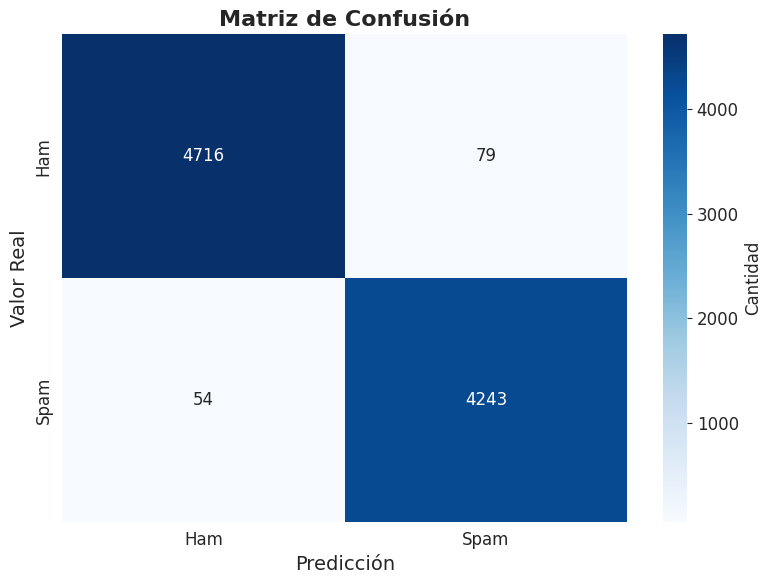

In [22]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'], ax=ax, cbar_kws={'label': 'Cantidad'})
ax.set_title('Matriz de Confusión', fontsize=16, fontweight='bold')
ax.set_xlabel('Predicción', fontsize=14)
ax.set_ylabel('Valor Real', fontsize=14)
plt.tight_layout()
plt.show()


## Guardar modelo y vectorizador

In [23]:
# Guardar modelo
joblib.dump(model, 'phishing_svm_model.pkl')
print("✅ Modelo guardado en 'phishing_svm_model.pkl'")

# Guardar vectorizador
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
print("✅ Vectorizador guardado en 'tfidf_vectorizer.pkl'")

✅ Modelo guardado en 'phishing_svm_model.pkl'
✅ Vectorizador guardado en 'tfidf_vectorizer.pkl'


## Prueba de carga y predicción

In [24]:
# Cargar modelo y vectorizador
loaded_model = joblib.load('phishing_svm_model.pkl')
loaded_tfidf = joblib.load('tfidf_vectorizer.pkl')

# Ejemplo de predicción
test_email = "Congratulations! You've won $1,000,000. Click here to claim your prize now!"
test_clean = preprocess_text(test_email)
test_vec = loaded_tfidf.transform([test_clean])
prediction = loaded_model.predict(test_vec)[0]

print(f"\n📧 Email de prueba:\n{test_email}")
print(f"\n🔍 Predicción: {'SPAM ⚠️' if prediction == 1 else 'HAM ✅'}")


📧 Email de prueba:
Congratulations! You've won $1,000,000. Click here to claim your prize now!

🔍 Predicción: SPAM ⚠️
